In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path 
plt.style.use("ggplot")

## Start. Feature analysis

Что сделать:
- 
- Посмотреть прошлые отчеты и удалить или добавить некоторые признаки

In [16]:
cwd = Path().cwd()
train_values = pd.read_csv(cwd / 'train_values (1).csv', index_col = False)
train_labels = pd.read_csv(cwd / 'train_labels (2).csv', index_col = False)
df = train_values.join(train_labels.set_index('building_id'), on= ['building_id'])
target = df.damage_grade
# df.drop('damage_grade', axis = 1, inplace = True)

In [17]:
cat_features = [feature for feature, type_ in zip(df.dtypes.index, df.dtypes) if type_ == 'object']
numeric_features = [feature for feature, type_ in zip(df.dtypes.index, df.dtypes) if type_ == 'int64' and feature != 'damage_grade']
binary_features = [feature for feature in numeric_features if 'has_' in feature]

In [4]:
df[df.age > 900]

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
386,435557,14,1120,3789,3,995,12,5,t,r,...,0,0,0,0,0,0,0,0,0,2
716,597626,26,39,1851,2,995,27,6,t,i,...,0,0,0,0,0,0,0,0,0,1
1235,7560,26,1132,9472,2,995,8,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1398,797271,26,39,1851,2,995,14,6,t,u,...,0,0,0,0,0,0,0,0,0,1
1635,857371,24,628,10750,2,995,10,5,t,r,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259758,160373,27,390,11020,3,995,6,8,n,r,...,0,0,0,0,0,0,0,0,0,2
259893,9269,24,628,11511,2,995,8,5,n,r,...,0,0,0,0,0,0,0,0,0,2
260093,34321,17,1393,5939,2,995,8,4,t,r,...,0,0,0,0,0,0,0,0,0,3
260542,156434,8,696,7863,2,995,8,8,t,r,...,0,0,0,0,0,0,0,0,0,3


In [18]:
df[['age', 'damage_grade']].groupby('age').value_counts()

age  damage_grade
0    2               12721
     1                7213
     3                6107
5    2               19030
     3                9077
                     ...  
200  3                  39
     1                   3
995  2                 822
     3                 389
     1                 179
Name: count, Length: 107, dtype: int64

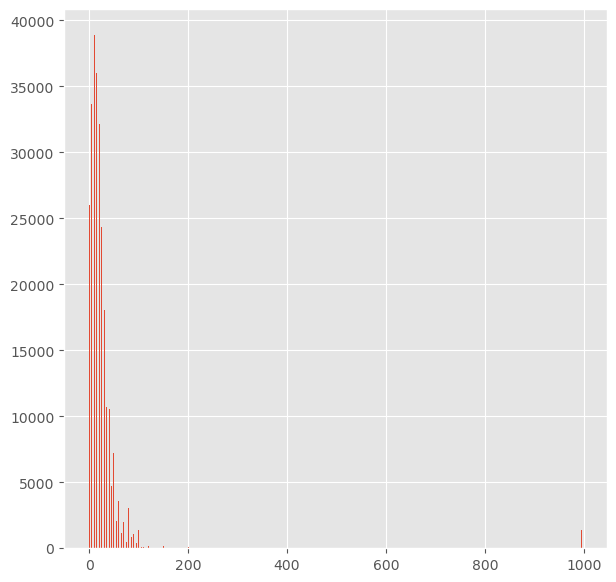

In [19]:
def get_age_plot(df, split):
    fig, ax = plt.subplots(figsize = (7,7))
    plot_values = df.age[(df.age <= split[1]) & (df.age >= split[0])].value_counts()
    ax.bar(plot_values.index, plot_values, width = 2)
    plt.show()
get_age_plot(df, [0, 1000])

## Preprocessing

Что доделать:
-
- Возможность менять метод обработки категориальных признаков
- Дописать (придумать как реализовать) оставшиеся методы
- Реализовать пару методов для работы с возрастом и geo_lvl_id
- Поменять accuracy на micro_f1_score
- Дописать методы для работы с данными финального предсказания (посмотреть, работают ли вообще)
- Реализовать automated feature engeneering
 

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [24]:
class GeoNetwork(nn.Module):
    def __init__(self):
        super(GeoNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        self.fc4 = nn.Linear(2, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        saved_layer = x
        x = self.fc4(x)
        return x, saved_layer
        
def fit_geo_model(df, target, num_epochs = 5, batch_size = 256):
    train, target = torch.FloatTensor(df.values), torch.FloatTensor(target)
    # x_train, y_train, x_test, y_test = train_test_split(train, tartet, test_size = 0.3)
    model = GeoNetwork()
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    loader = DataLoader(TensorDataset(train, target), batch_size = batch_size, shuffle = True)
    for epoch in range(num_epochs):
        for x_batch, y_batch in tqdm(loader):
            optimizer.zero_grad()
            preds, hidden_layer = model(x_batch)
            loss = criterion(preds.reshape(-1), y_batch)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    model.eval()
    with torch.no_grad():
        preds, hidden_layer = model(train)
        print(preds)
        print(hidden_layer)
        return preds, hidden_layer
    
preds, hidden_layer = fit_geo_model(df[['geo_level_2_id','geo_level_3_id']], df.geo_level_1_id)

100%|██████████| 1018/1018 [00:04<00:00, 224.69it/s]


Epoch [1/5], Loss: 78.73444366455078


100%|██████████| 1018/1018 [00:05<00:00, 181.79it/s]


Epoch [2/5], Loss: 107.03050994873047


100%|██████████| 1018/1018 [00:04<00:00, 217.86it/s]


Epoch [3/5], Loss: 80.48947143554688


100%|██████████| 1018/1018 [00:04<00:00, 226.26it/s]


Epoch [4/5], Loss: 83.80060577392578


100%|██████████| 1018/1018 [00:04<00:00, 204.98it/s]

Epoch [5/5], Loss: 84.23884582519531
tensor([[20.6611],
        [12.3603],
        [15.8330],
        ...,
        [15.1608],
        [ 5.2672],
        [16.6738]])
tensor([[  0.0000, 236.8966],
        [  0.0000, 132.1502],
        [  0.0000, 175.9716],
        ...,
        [  0.0000, 167.4898],
        [  0.0000,  42.6446],
        [  0.0000, 186.5820]])


In [30]:
pd.DataFrame(hidden_layer).value_counts()

0    1         
0.0  18.497513     651
     187.011734    647
     30.676277     530
     228.902206    470
     45.697659     466
                  ... 
     222.217606      1
     122.278084      1
     173.938370      1
     174.200363      1
     141.135117      1
Name: count, Length: 11588, dtype: int64

In [37]:
class Preprocessing:
    def __init__(self, df, df_predict = None, scaler = None):
        self.data = df.copy()
        self.scaler = scaler
        self.mean_encoding = []
        self.df_predict = df_predict

    def cat_features_Mean_Encoding(self, X, cat_features, y = None):
        if type(y) != type(None):
            temp_df = pd.concat([X, y], axis = 1)
            for feature in cat_features:
                mean_encoding_temp = temp_df.groupby(feature)['damage_grade'].mean()
                temp_df[feature] = temp_df[feature].map(mean_encoding_temp)
                self.mean_encoding.append(mean_encoding_temp)
            temp_df.drop('damage_grade', axis = 1, inplace = True)
            
            return temp_df
        else:
            if len(self.mean_encoding) != 0:
                X_res = X.copy()
                for feature, encoding in zip(cat_features, self.mean_encoding):
                    X_res[feature] = X_res[feature].map(encoding)  
                return X_res
            else:
                raise Exception("You don't encoding categorial features on train data")
        return temp_df
            
    def cat_features_Target_Encoding(self, cat_features):
        pass
        
    #Creatre columns with oldest buildings/....... now Im just delete this old buildings
    def get_old_build_col(self):
        self.data.drop(self.data[self.data.age >= 900].index, axis = 0, inplace = True)

    #Create columns with highest class probabilities
    def get_geo_lvl_col(self, num_epoch = 5, batch_size = 128):
        
        # train_1 = torch.utils.data.TensorDataset(torch.FloatTensor(self.data[['geo_level_2_id','geo_level_3_id']].values), torch.FloatTensor(self.data.geo_level_1_id))
        # train_2 = torch.utils.data.TensorDataset(torch.FloatTensor(self.data[['geo_level_1_id','geo_level_3_id']].values), torch.FloatTensor(self.data.geo_level_2_id))
        # train_3 = torch.utils.data.TensorDataset(torch.FloatTensor(self.data[['geo_level_1_id','geo_level_2_id']].values), torch.FloatTensor(self.data.geo_level_3_id))
        # train_1_loader = torch.utils.data.DataLoader(train_1, batch_size = batch_size, shuffle = True)
        # train_2_loader = torch.utils.data.DataLoader(train_2, batch_size = batch_size, shuffle = True)
        # train_3_loader = torch.utils.data.DataLoader(train_3, batch_size = batch_size, shuffle = True)
        # loaders = {'geo_1_loader': (train_1_loader, torch.FloatTensor(self.data[['geo_level_2_id','geo_level_3_id']].values)),
        #            'geo_2_loader': (train_2_loader,torch.FloatTensor(self.data[['geo_level_1_id','geo_level_3_id']].values)),
        #            'geo_3_loader': (train_3_loader, torch.FloatTensor(self.data[['geo_level_1_id','geo_level_2_id']].values))} 
        
        # model = GeoNetwork()
        # optimizer = optim.Adam(model.parameters(), lr=0.001)
        # criterion = nn.MSELoss()
        # for loader_name, loader in tqdm(loaders.items()):
        #     print(loader_name)
        #     for epoch in range(num_epoch):
        #         model.train()
        #         for x_batch, y_batch in loader[0]:
        #             optimizer.zero_grad()
        #             preds, hidden_layer = model(x_batch)
        #             loss = criterion(preds, y_batch)
        #             loss.backward()
        #             optimizer.step()
        #         print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item()}')
        #     model.eval()
        #     with torch.no_grad():
        #         preds, hidden_layer = model(loader[1])
        #         print(hidden_layer)
        #         print(preds
        pass
                
    # Try Min_Max_scaler, StandardScaler and ....
    def use_scaler(self, X, train_flag = True):
        X_res = X.copy()
        if train_flag:
            X_res = pd.DataFrame(self.scaler.fit_transform(X_res), index = X_res.index, columns = X_res.columns)
            return X_res
        else:
            X_res = pd.DataFrame(self.scaler.transform(X_res), index = X_res.index, columns = X_res.columns)
            return X_res
        
    def get_final_data(self, cat_features, numeric_features, test_size = 0.33, stratify = None):
        self.get_old_build_col()
        target = self.data['damage_grade']
        
        if not self.df_predict:
            self.data.drop('damage_grade', axis = 1, inplace = True)
            X_train, X_test, y_train, y_test = train_test_split(self.data, target, test_size = test_size, random_state = 42, stratify = stratify)

            if type(self.scaler) != None:
                X_train_numeric = self.use_scaler(X_train[numeric_features])
                X_test_numeric = self.use_scaler(X_test[numeric_features], train_flag = False)
                
            else:
                X_train_numeric = X_train[numeric_features]
                X_test_numeric = X_test[numeric_features]

            X_train_cat = self.cat_features_Mean_Encoding(X_train[cat_features], cat_features, y_train)
            X_test_cat = self.cat_features_Mean_Encoding(X_test[cat_features], cat_features)
            X_train_final = pd.concat([X_train_numeric, X_train_cat], axis = 1)
            X_test_final = pd.concat([X_test_numeric, X_test_cat], axis = 1)
        
            return X_train_final, X_test_final, y_train, y_test
        else:
            if type(self.scaler) != None:
                X_numeric = self.use_scaler(self.df_predict[numeric_features])
            else:
                X_numeric = self.df_predict[numeric_features]
            _ = self.cat_features_Mean_Encoding(self.data[cat_features], cat_features, target)
            X_cat = self.cat_features_Mean_Encoding(self.df_predict[cat_features], cat_features)
            X_final = pd.concat([X_numeric, X_cat], axis = 1)
            return X_final
                
            

In [38]:
train_1 = torch.utils.data.TensorDataset(torch.FloatTensor(df[['geo_level_2_id','geo_level_3_id']].values), torch.FloatTensor(df.geo_level_1_id))

In [39]:
preprocessing = Preprocessing(df, scaler = StandardScaler())
preprocessing.get_geo_lvl_col(num_epoch = 1)

## Model selection

- Поработать с результатами gridsearchcv и мб визуализировать парочку (Лучше реализовать собственный KFold + ParameterGrid и доставать из моделей только нужные параметры, короче преписать find_best_models)
- CatBoost - заняться отдельно, также разобратться с параметрах

In [21]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

class ModelSelection:
    def __init__(self, models, params_grid):
        self.models = models
        self.param_grids = params_grid
        self.best_model = None
        self.best_params = None
        self.best_score = 0
        
    def find_best_models(self, X, y, cv = 5, train_results_flag = False):
        best_models_params = dict()
        best_models_score = dict()
        models_cv_results = dict()
        for model_name, model in tqdm(models.items()):
            print(f'Traning {model_name}...')
            param_grid = param_grids[model_name]
            grid_search = GridSearchCV(model, param_grid, cv = cv, scoring = 'accuracy', n_jobs = -1) # Mb change metric
            grid_search.fit(X, y)
            
            best_models_params[model_name] = grid_search.best_params_
            best_models_score[model_name] = grid_search.best_score_
            models_cv_results[model_name] = grid_search.cv_results_
            
            if grid_search.best_score_ > self.best_score:
                self.best_model = grid_search.best_estimator_
                self.best_params = grid_search.best_params_
                self.best_score = grid_search.best_score_
                
        if train_results_flag:
            return best_models_params, best_models_score, models_cv_results

    def fit_best_model(self, X_train, y_train):
        if self.best_model:
            self.best_model = self.best_model.fit(X_train, y_train)
            # joblib.dumb(self.best_model, 'best_model.pkl')
        else:
            raise Exception("No best model found. Please run find_best_model first.")

    def predict(self, X_test):
        if self.best_model:
            return self.best_model.predict(X_test)        
        else:
            raise Exception("No best model found. Please run find_best_model first.")

    def evaluete(self, X_test, y_test):
        predictions = self.predict(X_test)                   
        return accuracy_score(y_test, predictions)    

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
models = {
    'tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    # 'SVM': SVC(),
    # 'logreg': LogisticRegression(),
}
    


# param_grids = {
#     'tree': {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': np.arange(10, 100, 30)},
#     'random_forest': {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [40, 45], 'max_features': ['sqrt', 'log2']},
#     # 'SVM': {'kernel': ['linear', 'poly']},
#     'Logreg':{'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [0.1, 1, 10]}
# }

param_grids = {
    'tree': {'max_depth': np.arange(10, 21, 10)},
    'random_forest': {'max_depth': [30, 40], 'criterion': ['gini', 'entropy']},
    # 'logreg': {'penalty': ['l1', 'l2', 'elasticnet'], 'C' : [0.1, 1, 10]},
                      
}
preprocessing = Preprocessing(df, scaler = StandardScaler())
X_train, X_test, y_train, y_test = preprocessing.get_final_data(cat_features, numeric_features)

selector = ModelSelection(models, param_grids)
best_models_params, best_models_score, models_cv_results = selector.find_best_models(X_train, y_train, train_results_flag = True)

  0%|          | 0/3 [00:00<?, ?it/s]

Traning tree...


 33%|███▎      | 1/3 [00:07<00:14,  7.31s/it]

Traning random_forest...


 67%|██████▋   | 2/3 [03:33<02:04, 124.52s/it]

Traning logreg...


\\?\C:\Users\budar\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "\\?\C:\Users\budar\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "\\?\C:\Users\budar\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [23]:
print(selector.best_model)
print(selector.best_score)
print(selector.best_params)

RandomForestClassifier(max_depth=40)
0.7185255587370125
{'criterion': 'gini', 'max_depth': 40}


In [24]:
selector.fit_best_model(X_train, y_train)

accuracy = selector.evaluete(X_test, y_test)
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.7204386097512762


In [27]:
print(best_models_params)
print(best_models_score)
selector.best_model

{'tree': {'max_depth': 10}, 'random_forest': {'criterion': 'gini', 'max_depth': 40}, 'logreg': {'C': 1, 'penalty': 'l2'}}
{'tree': 0.6820712181542282, 'random_forest': 0.7185255587370125, 'logreg': 0.5867687765410475}


RandomForestClassifier(max_depth=40)